 [Link to tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

# Data

In [0]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls data

eng-fra.txt  names


In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import torch
import torch.nn as nn
import random
import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string
from IPython.core.display import Image, display

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/French.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Japanese.txt', 'data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Korean.txt', 'data/names/Russian.txt', 'data/names/Italian.txt', 'data/names/Spanish.txt', 'data/names/Polish.txt', 'data/names/Dutch.txt', 'data/names/Vietnamese.txt', 'data/names/Scottish.txt', 'data/names/Arabic.txt', 'data/names/Greek.txt']
ERROR! Session/line number was not unique in database. History logging moved to new session 60


In [0]:
! head data/names/French.txt

Abel
Abraham
Adam
Albert
Allard
Archambault
Armistead
Arthur
Augustin
Babineaux


# Character level classification

In [0]:

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

<img src="https://i.imgur.com/Z2xbySO.png" width="640">

In [0]:

class RNN_Cell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_Cell, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN_Cell(n_letters, n_hidden, n_categories)

In [0]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [0]:
output

tensor([[-2.7488, -2.9780, -2.9054, -2.9658, -2.9181, -2.9363, -2.8764, -2.9298,
         -2.9350, -2.8907, -2.8176, -2.8866, -2.9023, -2.9083, -2.8708, -2.8091,
         -2.9427, -2.8347]], grad_fn=<LogSoftmaxBackward>)

In [0]:
next_hidden

tensor([[-1.1416e-02,  2.0970e-02, -5.0721e-02,  8.2549e-02,  9.0021e-02,
         -7.3125e-02,  5.4685e-02, -1.0801e-01, -7.8748e-02, -8.4945e-02,
          1.0814e-01, -5.2015e-02, -5.2228e-02, -3.8268e-02,  1.6816e-02,
         -9.5503e-02, -1.0117e-01, -7.9991e-02,  5.1312e-02, -2.5828e-02,
         -4.6381e-02, -6.1443e-02, -6.6677e-02,  7.4520e-02,  1.7998e-02,
          2.7203e-02, -6.3172e-02, -6.9894e-03, -5.1590e-02,  5.8490e-02,
          5.5827e-02, -9.0540e-02,  9.0296e-02,  1.6924e-02,  1.1576e-02,
         -2.6912e-02, -1.1501e-01,  2.5052e-02, -5.7170e-02,  4.1206e-02,
         -1.1840e-01, -1.9160e-02,  1.0129e-01,  5.1793e-03, -5.6341e-02,
          6.3834e-02, -3.4888e-02,  5.0493e-02, -7.7204e-02, -4.5815e-02,
          3.3691e-02, -1.3506e-01, -1.9509e-02,  7.0457e-03, -3.5010e-02,
          6.5059e-02, -2.5308e-02, -4.2881e-02,  1.0193e-02, -2.3619e-02,
          4.7989e-02,  7.9993e-03,  7.0731e-02, -2.0997e-02, -9.7590e-02,
         -7.2397e-02, -3.2765e-02, -9.

In [0]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Brahms
category = Korean / line = Hwang
category = Irish / line = Sechnall
category = Arabic / line = Ghanem
category = Arabic / line = Fakhoury
category = Scottish / line = Gibson
category = English / line = Virgo
category = Japanese / line = Ichimonji
category = Spanish / line = Rodriquez
category = Italian / line = Caivano


In [0]:

def train_step(rnn_cell, category_tensor, line_tensor, optimizer, criterion):
    hidden = rnn_cell.initHidden()

    rnn_cell.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn_cell(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [0]:
n_iters = 100000
print_every = 5000
plot_every = 1000
rnn_cell = RNN_Cell(n_letters, n_hidden, n_categories)
optimizer = torch.optim.Adam(rnn_cell.parameters(), lr=0.001)
criterion = nn.NLLLoss()


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_step(category_tensor, line_tensor, rnn_cell, optimizer, criterion)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 0.5387 Wilson / Scottish ✓
10000 10% (0m 16s) 1.7917 Lao / Vietnamese ✗ (Chinese)
15000 15% (0m 25s) 0.0614 Youn / Korean ✓
20000 20% (0m 33s) 0.3350 Mar / Chinese ✓
25000 25% (0m 41s) 0.8652 Nicodemo / Italian ✓
30000 30% (0m 50s) 2.4170 Garcon / Irish ✗ (French)
35000 35% (0m 58s) 1.9404 Derrick / Czech ✗ (German)
40000 40% (1m 6s) 3.7488 Niftrik / Czech ✗ (Dutch)
45000 45% (1m 15s) 0.0440 O'Rourke / Irish ✓
50000 50% (1m 23s) 1.0221 Chan / Korean ✗ (Chinese)
55000 55% (1m 31s) 1.6718 Gonzalez / Polish ✗ (Spanish)
60000 60% (1m 40s) 0.3515 Nghiem / Vietnamese ✓
65000 65% (1m 48s) 1.0064 Bang / Korean ✓
70000 70% (1m 56s) 3.0668 Ohme / Japanese ✗ (German)
75000 75% (2m 5s) 1.2612 Exton / English ✓
80000 80% (2m 13s) 0.0364 Thao / Vietnamese ✓
85000 85% (2m 21s) 0.7277 Rui / Chinese ✓
90000 90% (2m 30s) 1.4852 Romao / Spanish ✗ (Portuguese)
95000 95% (2m 38s) 0.0022 Zelentsov / Russian ✓
100000 100% (2m 46s) 0.3641 Rezac / Czech ✓


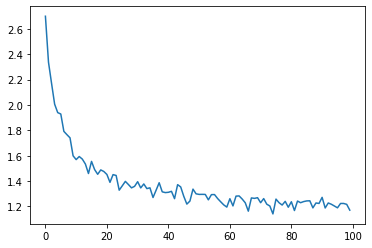

In [0]:
plt.figure()
plt.plot(all_losses)

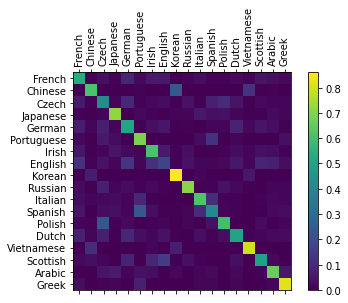

In [0]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [0]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Doevsky')
predict('Jackson')
predict('Satoshi')
predict('Lie')


> Doevsky
(-0.59) Russian
(-1.01) Czech
(-2.82) English

> Jackson
(-1.38) English
(-1.63) Russian
(-1.73) Scottish

> Satoshi
(-0.62) Japanese
(-1.65) Arabic
(-2.01) Italian

> Lie
(-0.62) Chinese
(-1.23) Korean
(-2.58) French


# Character level generation

<img src="https://i.imgur.com/jzVrf7f.png" width="640">

In [0]:
class RNN_Cell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_Cell, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [0]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [0]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [0]:


def train_step(rnn_cell, next_input, optimizer, criterion):
    (category_tensor, input_line_tensor, target_line_tensor) = next_input
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn_cell.initHidden()

    rnn_cell.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn_cell(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

In [0]:

rnn_cell = RNN_Cell(n_letters, n_hidden, n_letters)
optimizer = torch.optim.Adam(rnn_cell.parameters(), lr=0.0001)
criterion = nn.NLLLoss()
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train_step(rnn_cell, randomTrainingExample(), optimizer, criterion)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 19s (5000 5%) 2.5629
0m 40s (10000 10%) 2.5562
0m 59s (15000 15%) 2.7607
1m 17s (20000 20%) 2.2436
1m 36s (25000 25%) 2.6681
1m 54s (30000 30%) 2.5401
2m 13s (35000 35%) 2.0131
2m 31s (40000 40%) 2.3844


KeyboardInterrupt: ignored

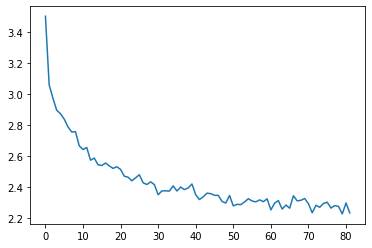

In [0]:
plt.figure()
plt.plot(all_losses)

In [0]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn_cell(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

print ('Russian samples\n')
samples('Russian', 'RUS')

print ('\nGerman samples\n')
samples('German', 'GER')
print ('\nSpanish samples\n')
samples('Spanish', 'SPA')
print ('\nChinese samples\n')
samples('Chinese', 'CHI')

Russian samples

Roukov
Urakov
Shavan

German samples

Grenger
Eler
Romer

Spanish samples

Salla
Parer
Allan

Chinese samples

Chan
Hou
Iun
